In [ ]:
"""
This example solves a plug-flow reactor problem of hydrogen-oxygen combustion.
The PFR is computed by two approaches: The simulation of a Lagrangian fluid
particle, and the simulation of a chain of reactors.

Requires: cantera >= 2.5.0, matplotlib >= 2.0
Keywords: combustion, reactor network, plug flow reactor
"""

In [1]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

# Information from Paper

- PFR model (reactor length of 10 cm and internal diameter of 0.5 cm)
- operated at 1 atm, 500-1500 K, residence time of 25 s
- inlet stream: 2% mol of perfluoropentanoic acid in N2 (i.e. pure pyrolytic conditions)

In [2]:
#####################################################################
# Input Parameters
#####################################################################
def calc_mole_fractions(temp):
    T_0 = temp #range is from 500-1500 K so i'll say starting in 500 K 
    pressure = ct.one_atm  # constant pressure
    length = .1  # *approximate* PFR length [m]
    int_diam= 0.005 # m
    res_time = 25 # s   # res_time = reactor volume (Vr) / constant volumetric flow rate (q)  
    u_0 = length/res_time #inflow velocity [m/s]  #velocity = length of PFR /residence time (assuming ideal PFR with no back mixing)
    radius = int_diam/2 
    cross_area = np.pi*radius*radius #cross sectional area [m**2]
    Vr = cross_area*length # [m] # Vr = pi*r*r * length
    q = Vr/res_time #volumetric flow 

    #input file containing the reaction mechanism
    reaction_mechanism = ('/work/westgroup/nora/Code/projects/PFAS/models/PFPA/cantera/chem_annotated.cti')
    #initial composition
    composition_0 = 'PFPA(1):.02, N2:.98'  #2% mol PFPA, rest is N2


    # Resolution: The PFR will be simulated by 'n_steps' time steps 
    n_steps = 4000
    #######################################################################



    #####################################################################
    # Method 1: Lagrangian Particle Simulation
    #####################################################################
    # A Lagrangian particle is considered which travels through the PFR. Its
    # state change is computed by upwind time stepping. The PFR result is produced
    # by transforming the temporal resolution into spatial locations.
    # The spatial discretization is therefore not provided a priori but is instead
    # a result of the transformation.

    # import the gas model and set the initial conditions
    gas1 = ct.Solution(reaction_mechanism)
    gas1.TPX = T_0, pressure, composition_0
    mass_flow_rate1 = q * gas1.density  # had this in example file: u_0 * gas1.density * area

    # create a new reactor
    r1 = ct.IdealGasConstPressureReactor(gas1)
    # A homogeneous, constant pressure, zero-dimensional reactor for ideal gas mixtures. The volume of the reactor changes as a function of time in order to keep the pressure constant.

    # create a reactor network for performing time integration
    sim1 = ct.ReactorNet([r1])
    # Networks of reactors. These objects are used to simultaneously advance the state of one or more coupled reactors. 

    # approximate a time step to achieve a similar resolution as in the next method
    t_total = res_time #was length / u_0 
    dt = t_total/n_steps

    #define time, space, and other information vectors 
    t1 = (np.arange(n_steps)+1)*dt #vector of time
    z1 = np.zeros_like(t1) #spatial vector
    u1 = np.zeros_like(t1) #velocity vector

    states1 = ct.SolutionArray(r1.thermo) #empty solution array
    #SolutionArray class uses Solution object and computes properties for that array of states. 
    #Can represent both 1D and multi-dimensional arrays of states

    #.thermo is the ThermoPhase object representing the reactor's contents. 

    #this is the time vector 
    
    for n1, t_i in enumerate(t1): 
        #perform time integration
        sim1.advance(t_i)
        # compute velocity and transform into space 
        u1[n1]= mass_flow_rate1 / cross_area / r1.thermo.density
        z1[n1] = z1[n1 - 1] + u1[n1] * dt #distance before, plus distance traveled during time step
        states1.append(r1.thermo.state) 
    # r1.thermo.state: Get/Set the full thermodynamic state as a single array, arranged as [temperature, density, mass fractions] for most phases. Useful mainly in cases where it is desired to store many states in a multidimensional array.
    
#     PFPA_X_2 = states1.X[:, gas1.species_index('PFPA(1)')][319]    # this is the index for time = 2s with n_steps = 4000
#     PFPA_X_25 = states1.X[:, gas1.species_index('PFPA(1)')][3999]  # this is the index for time = 25 s with n_steps = 4000
#     N2_X_25 = states1.X[:, gas1.species_index('N2')][3999]
    
    return states1, gas1

    # states1.write_csv('test.csv')


    # plt.figure()
    # # plt.plot(states1.T, states1.Y_PFPA(1), label='Lagrangian Particle')
    # plt.plot(t1, states1.Y[:, gas1.species_index('PFPA(1)')], label='Lagrangian Particle')




In [4]:
#this will tell me which row corresponds to which time period
for index, time in enumerate(t1):
    print(time, index)

NameError: name 't1' is not defined

In [5]:
sp = '''    N2                  ! N2
    Ne                  ! Ne
    PFPA(1)             ! PFPA(1)
    H(2)                ! H(2)
    O2(3)               ! O2(3)
    O(4)                ! O(4)
    OH(5)               ! OH(5)
    H2(6)               ! H2(6)
    H2O(7)              ! H2O(7)
    Ar(8)               ! Ar(8)
    He(9)               ! He(9)
    HO2(10)             ! HO2(10)
    H2O2(11)            ! H2O2(11)
    CO(12)              ! CO(12)
    CO2(13)             ! CO2(13)
    HCO(14)             ! HCO(14)
    C(T)(15)            ! C(T)(15)
    CH(16)              ! CH(16)
    CH2(T)(17)          ! CH2(T)(17)
    CH3(18)             ! CH3(18)
    CH2O(19)            ! CH2O(19)
    HCCO(20)            ! HCCO(20)
    C2H(21)             ! C2H(21)
    C2H2(22)            ! C2H2(22)
    H2CC(23)            ! H2CC(23)
    CH2(S)(24)          ! CH2(S)(24)
    CH3OH(25)           ! CH3OH(25)
    CH3O(26)            ! CH3O(26)
    CH2CO(27)           ! CH2CO(27)
    C2H3(28)            ! C2H3(28)
    C2H4(29)            ! C2H4(29)
    CH4(30)             ! CH4(30)
    C2H6(31)            ! C2H6(31)
    C2H5(32)            ! C2H5(32)
    CH2OH(33)           ! CH2OH(33)
    CH3CO(34)           ! CH3CO(34)
    CH2CHO(35)          ! CH2CHO(35)
    CH3CHO(36)          ! CH3CHO(36)
    HF(38)              ! HF(38)
    CHF3(42)            ! CHF3(42)
    CF2(43)             ! CF2(43)
    CF4(44)             ! CF4(44)
    CF3(45)             ! CF3(45)
    CFO(51)             ! CFO(51)
    C2F6(53)            ! CF3-CF3(53)
    CHFCF2(55)          ! CHFCF2(55)
    CF2CF2(61)          ! CF2CF2(61)
    C2HF4(69)           ! CHF2-CF2(69)
    CF3CO(74)           ! CF3CO(74)
    CHF2(82)            ! CHF2(82)
    S(125)              ! OC(F)(F)C(F)(F)C(F)(F)C(F)(F)F(125)
    S(142)              ! O=C(O)C(F)(F)[C](F)C(F)(F)C(F)(F)F(142)
    C2F5(149)           ! F[C](F)C(F)(F)F(149)
    CHO2(153)           ! O=[C]O(153)
    C4F9(154)           ! F[C](F)C(F)(F)C(F)(F)C(F)(F)F(154)
    C4F8(158)           ! FC(F)=C(F)C(F)(F)C(F)(F)F(158)
    C4F8(165)           ! FC(=C(F)C(F)(F)F)C(F)(F)F(165) #perfluoro-2-butene
    C4F7(166)           ! F[C](F)C(F)=C(F)C(F)(F)F(166)
    C4F8(172)           ! FC(F)(F)[C]C(F)(F)C(F)(F)F(172)
    C4F6(174)           ! FC(F)=C(F)C(F)=C(F)F(174)
    C4F8O(263)          ! O=C(F)C(F)(F)C(F)(F)C(F)(F)F(263)
    C4F8O(342)          ! FC(F)=C(F)OC(F)(F)C(F)(F)F(342)
    C2F3O(347)          ! O=C(F)[C](F)F(347)
    C6F12(406)          ! F[C](F)C(F)(F)C(F)(F)[C](F)C(F)(F)C(F)(F)F(406)
    C6F12(407)          ! F[C](F)C(F)(F)C(F)([C](F)F)C(F)(F)C(F)(F)F(407)
    C4F6(494)           ! F[C](F)C(F)=C(F)[C](F)F(494)
    C3HF6(498)          ! F[CH]C(F)(F)C(F)(F)F(498)
    C4HF8(509)          ! FC(F)(F)[CH]C(F)(F)C(F)(F)F(509)
    C3HF5(588)          ! FC(F)=CC(F)(F)F(588)
    C6F12(757)          ! F[C](F)C(F)(F)C(F)([C](F)C(F)(F)F)C(F)(F)F(757)
    S(769)              ! O=C(O)C(F)([C](F)F)C(F)(F)C(F)(F)F(769)
    S(826)              ! O=C(O)[C](C(F)(F)F)C(F)(F)C(F)(F)F(826)
    C4F6(1630)     '''.split('\n')

model_species = []
for line in sp: 
    match = re.search('   ([\S]+)    ', line)
    model_species.append(match.group(1))  

In [6]:
for i in model_species: 
    print('\''+i+'\',')

'N2',
'Ne',
'PFPA(1)',
'H(2)',
'O2(3)',
'O(4)',
'OH(5)',
'H2(6)',
'H2O(7)',
'Ar(8)',
'He(9)',
'HO2(10)',
'H2O2(11)',
'CO(12)',
'CO2(13)',
'HCO(14)',
'C(T)(15)',
'CH(16)',
'CH2(T)(17)',
'CH3(18)',
'CH2O(19)',
'HCCO(20)',
'C2H(21)',
'C2H2(22)',
'H2CC(23)',
'CH2(S)(24)',
'CH3OH(25)',
'CH3O(26)',
'CH2CO(27)',
'C2H3(28)',
'C2H4(29)',
'CH4(30)',
'C2H6(31)',
'C2H5(32)',
'CH2OH(33)',
'CH3CO(34)',
'CH2CHO(35)',
'CH3CHO(36)',
'HF(38)',
'CHF3(42)',
'CF2(43)',
'CF4(44)',
'CF3(45)',
'CFO(51)',
'C2F6(53)',
'CHFCF2(55)',
'CF2CF2(61)',
'C2HF4(69)',
'CF3CO(74)',
'CHF2(82)',
'S(125)',
'S(142)',
'C2F5(149)',
'CHO2(153)',
'C4F9(154)',
'C4F8(158)',
'C4F8(165)',
'C4F7(166)',
'C4F8(172)',
'C4F6(174)',
'C4F8O(263)',
'C4F8O(342)',
'C2F3O(347)',
'C6F12(406)',
'C6F12(407)',
'C4F6(494)',
'C3HF6(498)',
'C4HF8(509)',
'C3HF5(588)',
'C6F12(757)',
'S(769)',
'S(826)',
'C4F6(1630)',


In [7]:
species_of_interest = [
# 'N2',  
# 'Ne',
'PFPA(1)', # keep this
# 'H(2)',
# 'O2(3)', 
# 'O(4)',
# 'OH(5)',
# 'H2(6)',
# 'H2O(7)',
# 'Ar(8)',
# 'He(9)',
# 'HO2(10)',
# 'H2O2(11)',
'CO(12)', #keep this
'CO2(13)', #keep this
# 'HCO(14)',
# 'C(T)(15)',
# 'CH(16)',
# 'CH2(T)(17)',
# 'CH3(18)',
# 'CH2O(19)',
# 'HCCO(20)',
# 'C2H(21)',
# 'C2H2(22)',
# 'H2CC(23)',
# 'CH2(S)(24)',
# 'CH3OH(25)',
# 'CH3O(26)',
# 'CH2CO(27)',
# 'C2H3(28)',
# 'C2H4(29)',
# 'CH4(30)',
# 'C2H6(31)',
# 'C2H5(32)',
# 'CH2OH(33)',
# 'CH3CO(34)',
# 'CH2CHO(35)',
# 'CH3CHO(36)',
'HF(38)',   # keep this
'CHF3(42)', #keep this
'CF2(43)',  #keep this
'CF4(44)', #keep this 
# 'CF3(45)', 
# 'CFO(51)',
'C2F6(53)', #keep this 
# 'CHFCF2(55)',
# 'CF2CF2(61)',
# 'C2HF4(69)',
# 'CF3CO(74)',
# 'CHF2(82)',
# 'S(125)',
# 'S(142)',
# 'C2F5(149)',
# 'CHO2(153)',
'C4F9(154)', #keep this 
'C4F8(158)', # keep this 
'C4F8(165)', #keep this 
# 'C4F7(166)',
# '72)',
'C4F6(174)',# keep this 
'C4F8O(263)',  ## keep this 
# 'C4F8O(342)',
# 'C2F3O(347)',
# 'C6F12(406)',
# 'C6F12(407)',
# 'C4F6(494)',
# 'C3HF6(498)',
# 'C4HF8(509)',
# 'C3HF5(588)',
# 'C6F12(757)',
# 'S(769)',
# 'S(826)',
# 'C4F6(1630)'
]

#missing from model: CF2O, C2F4,C3HF7, C3F6 

Mole fraction of species other than N2, will be normalizing by this number:
0.020000000018890973
0.020000000114731277
0.02000000062261592
0.020000003050454115
0.02000001361701309
0.020000055834316004
0.02000021183365331
0.020000748524388677
0.0200024771257842
0.02000771375597763
0.02002270249009075
0.020063390516608954
0.020168397908087908
0.020426144404499164
0.02102596590335118
0.02233794009458878
0.02499052930923523
0.029806566919639
0.0372868736047563
0.046496364546357055
0.05423442360711182
0.05743189593884402
0.057890823489750255
0.05807145132127891
0.05835081230947996
0.058823960048655886
0.05954514017683999
0.060258798189002746
0.06066702047419637
0.06094649041108396
0.06133566407245198
0.061885655850365845
0.06261231176415179
0.06357430773994087
0.06479226779177903
0.06614348796078579
0.06738258784754897
0.06834512205642411
0.06909655174937951
0.06975413373024708
0.07033401926995389
0.07078057408068825
0.07101849571131612
0.07117550691794865
0.07134143398728314
0.0715122388678

NameError: name 'PFPA_25_seconds_x' is not defined

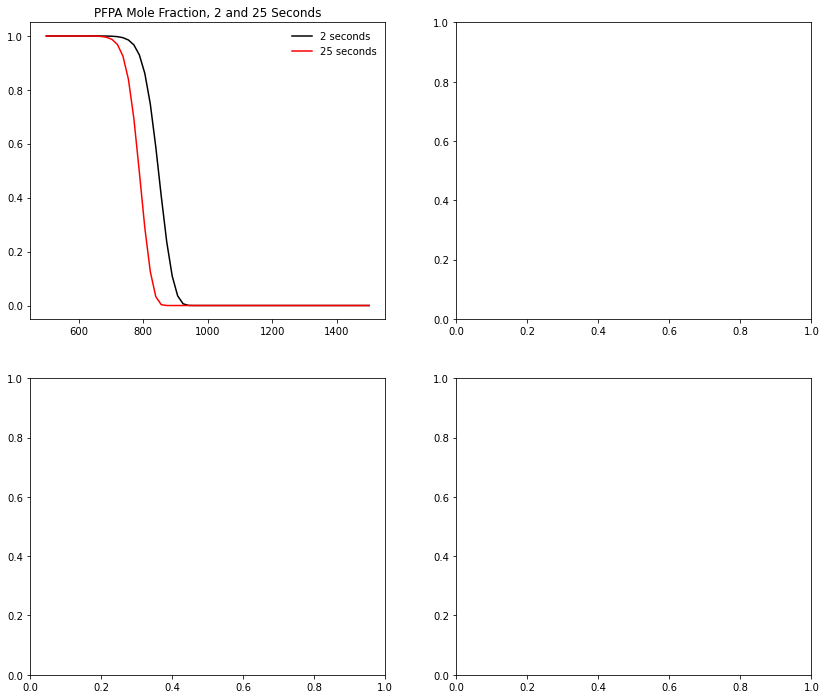

In [8]:
# with 4000 time steps, t1[319] is 2.0 seconds and t1[3999] is 25 seconds
#some problems: mole fraction is not a great indicator, since total moles changing. Not comparable across temperatures, but comparable across 2 and 25 second lines. 

temperatures = np.linspace(500,1500,60)

solution_dictionary = {}
#manually add in PFPA_2 
solution_dictionary['PFPA(1), 2 seconds']=np.array([])

#add in the other species 
for species in species_of_interest: 
    solution_dictionary[species]=np.array([])

#calculate across various temperatures
print('Mole fraction of species other than N2, will be normalizing by this number:')


#save total mole fractions across diff temps, 25 seconds
tot_moles_other_than_N2_25seconds =[]
#save total mole fractions across diff temps, 25 seconds
tot_moles_other_than_N2_2seconds = []

for temp in temperatures: 
    states1, gas1 = calc_mole_fractions(temp)
    
    #normalizing for 25 seconds 
    total_mole_fraction_other_than_N2 = 0
    for spec in gas1.species(): 
        name = spec.name
        if name!='N2':
            X_25 = states1.X[:, gas1.species_index(name)][3999]  # this is the index for time = 25 s with n_steps = 4000
            total_mole_fraction_other_than_N2 += X_25
    
    print(total_mole_fraction_other_than_N2)
    tot_moles_other_than_N2_25seconds.append(total_mole_fraction_other_than_N2)
    
    #normalizing for 2 seconds
    total_mole_fraction_other_than_N2_2seconds = 0
    for spec in gas1.species(): 
        name = spec.name
        if name!='N2':
            X_2 = states1.X[:, gas1.species_index(name)][319]  # this is the index for time = 25 s with n_steps = 4000
            total_mole_fraction_other_than_N2_2seconds += X_2
            
    tot_moles_other_than_N2_2seconds.append(total_mole_fraction_other_than_N2_2seconds)
    
    
    
    
    PFPA_X_2 = states1.X[:, gas1.species_index('PFPA(1)')][319]    # this is the index for time = 2s with n_steps = 4000
    
    #update the array and add it back into the dictionary
    updated = np.append(solution_dictionary['PFPA(1), 2 seconds'], PFPA_X_2)
    solution_dictionary['PFPA(1), 2 seconds'] = updated
    
########## specify which species of interest you want to plot 
    for species in species_of_interest: 
        
        #pick out the species mole fractions that you want
        X_25 = states1.X[:, gas1.species_index(species)][3999]  # this is the index for time = 25 s with n_steps = 4000
        updated = np.append(solution_dictionary[species], X_25)
        solution_dictionary[species]=updated

#normalize the fractions in respect to initial mole fraction of PFPA, divide by mole fractions for everything by 0.02 (initial mole fraction of PFPA)    
## still have to do this 
    
fig, axs = plt.subplots(2, 2, figsize=(14,12))

#manually plotting the two first lines: 
axs[0,0].plot(temperatures,np.array(solution_dictionary['PFPA(1), 2 seconds'])/tot_moles_other_than_N2_2seconds, c="black", label='2 seconds')
axs[0,0].plot(temperatures,np.array(solution_dictionary['PFPA(1)'])/tot_moles_other_than_N2_25seconds, c="r", label='25 seconds')
axs[0,0].set_title('PFPA Mole Fraction, 2 and 25 Seconds')
axs[0,0].legend(loc='upper right', frameon=False)
axs[0,0].plot(PFPA_25_seconds_x, PFPA_25_seconds_y, '*', c='r')
axs[0,0].plot(PFPA_2_seconds_x, PFPA_2_seconds_y, '*', c='black')


for key, value in color_dictionary_1.items():
    axs[0,1].plot(temperatures, solution_dictionary[key]/tot_moles_other_than_N2_25seconds, c=color_dictionary_1[key], label=key)
    axs[0,1].set_xlim([800,1500])
    axs[0,1].legend(bbox_to_anchor=(1,1), frameon=False)  
    axs[0,1].plot(exp_dict[key][0], exp_dict[key][1], '*', c=color_dictionary_1[key])

for key, value in color_dictionary_2.items():
    axs[1,0].plot(temperatures, solution_dictionary[key]/tot_moles_other_than_N2_25seconds, c=color_dictionary_2[key], label=key)
    axs[1,0].set_xlim([800,1500])
    axs[1,0].legend(loc='upper left', frameon=False)
    axs[1,0].plot(exp_dict[key][0], exp_dict[key][1], '*', c=color_dictionary_2[key])

for key, value in color_dictionary_3.items():
    axs[1,1].plot(temperatures, solution_dictionary[key]/tot_moles_other_than_N2_25seconds, c=color_dictionary_3[key], label=key)   
    axs[1,1].set_xlim([800,1500])
    axs[1,1].legend(loc='upper right', frameon=False)  
    axs[1,1].plot(exp_dict[key][0], exp_dict[key][1], '*', c=color_dictionary_3[key])

    
for ax in axs.flat:
    ax.set(xlabel='T (K)', ylabel='Mole Fraction')

exp_dict={'C4F8O(263)':[C3F7COF_x, C3F7COF_y],
    'HF(38)': [HF_x, HF_y],
    'CO(12)': [CO_x, CO_y],
    'C4F8(158)':[perfluoro_1_butene_x, perfluoro_1_butene_y],
    'CO2(13)': [CO2_x, CO2_y],
    'CF2(43)': [CF2_x, CF2_y],
    'CF4(44)': [CF4_x, CF4_y],
    'C2F6(53)': [C2F6_x, C2F6_y],
    'C4F9(154)': [C4F9_x, C4F9_y],
    'C4F8(165)': [C4F8_x, C4F8_y],
    'C4F6(174)': [C4F6_x, C4F6_y],
    'CHF3(42)': [CHF3_x, CHF3_y]}

# PFPA is degraded at lower temperatures than expected 2021 Altarawneh Paper

In [18]:
color_dictionary_1={'C4F8O(263)': 'black',
    'HF(38)': 'r' ,
    'CO(12)': 'b',
    'C4F8(158)': 'green',
    'CO2(13)': 'tab:olive',
    'CF2(43)': 'navy',
}


color_dictionary_2 = {'CF4(44)': 'b',
 'C2F6(53)': 'purple',
 'C4F9(154)': 'green',
 'C4F8(165)': 'brown',
 'C4F6(174)': 'orange'
}

color_dictionary_3 = {'CHF3(42)': 'black'}



 #'PFPA(1)': 'r', 

experimentals 

In [22]:
#plot 0,0

PFPA_25_seconds = [751.0344827586207, 0.9983870967741939,
800.6896551724138, 0.9887096774193551,
850.344827586207, 0.8895161290322584,
900, 0.395967741935484,
949.655172413793, 0.001612903225806317,
998.6206896551723, -0.0008064516129031585,
1048.2758620689656, -0.0008064516129031585,
1098.6206896551723, 0.001612903225806317]

PFPA_25_seconds_x = [val for index, val in enumerate(PFPA_25_seconds) if index%2==0]
PFPA_25_seconds_y = [val for index, val in enumerate(PFPA_25_seconds) if index%2!=0]



PFPA_2_seconds = [750.344827586207, 1.0008064516129036,
800.6896551724138, 1.0008064516129036,
849.6551724137931, 0.9935483870967745,
899.3103448275863, 0.9282258064516132,
949.655172413793, 0.6185483870967744,
999.3103448275863, 0.07903225806451619,
1048.9655172413793, -0.0008064516129031585,
1098.6206896551723, 0.001612903225806317]

PFPA_2_seconds_x = [val for index, val in enumerate(PFPA_2_seconds) if index%2==0]
PFPA_2_seconds_y = [val for index, val in enumerate(PFPA_2_seconds) if index%2!=0]


#plot 0,1

C3F7COF = [800, 0.00033670033670030186,
900.8403361344538, 0.22390572390572394,
1000.2801120448178, 0.2441077441077441,
1101.1204481792715, 0.21043771043771042,
1200.5602240896358, 0.16599326599326597,
1300, 0.08653198653198657,
1400.8403361344535, 0.0016835016835017313,
1503.081232492997, 0.00033670033670030186]

C3F7COF_x = [val for index, val in enumerate(C3F7COF) if index%2==0]
C3F7COF_y = [val for index, val in enumerate(C3F7COF) if index%2!=0]

HF=[800, 0.011111111111111072,
900.8403361344538, 0.26430976430976433,
1000.2801120448178, 0.3235690235690236,
1101.1204481792715, 0.31818181818181823,
1200.5602240896358, 0.3074074074074074,
1300, 0.2791245791245791,
1400.8403361344535, 0.2212121212121212,
1501.6806722689075, 0.2090909090909091]

HF_x = [val for index, val in enumerate(HF) if index%2==0]
HF_y = [val for index, val in enumerate(HF) if index%2!=0]

CO = [800, 0.011111111111111072,
900.8403361344538, 0.22390572390572394,
1000.2801120448178, 0.2441077441077441,
1101.1204481792715, 0.2090909090909091,
1201.9607843137255, 0.1740740740740741,
1300, 0.1525252525252525,
1400.8403361344535, 0.16464646464646465,
1501.6806722689075, 0.11077441077441075]

CO_x = [val for index, val in enumerate(CO) if index%2==0]
CO_y = [val for index, val in enumerate(CO) if index%2!=0]

perfluoro_1_butene = [798.5994397759104, 0.0016835016835017313,
900.8403361344538, 0.04208754208754206,
1000.2801120448178, 0.07845117845117844,
1101.1204481792715, 0.10942760942760943,
1199.159663865546, 0.139057239057239,
1301.4005602240895, 0.16329966329966328,
1400.8403361344535, 0.06902356902356899,
1503.081232492997, 0.00033670033670030186]


perfluoro_1_butene_x = [val for index, val in enumerate(perfluoro_1_butene) if index%2==0]
perfluoro_1_butene_y = [val for index, val in enumerate(perfluoro_1_butene) if index%2!=0]

CO2 = [800, 0.0016835016835017313,
900.8403361344538, 0.048821548821548766,
998.8795518207282, 0.09191919191919196,
1101.1204481792715, 0.1269360269360269,
1199.159663865546, 0.16329966329966328,
1300, 0.18484848484848482,
1400.8403361344535, 0.17003367003367004,
1503.081232492997, 0.1579124579124579]

CO2_x = [val for index, val in enumerate(CO2) if index%2==0]
CO2_y = [val for index, val in enumerate(CO2) if index%2!=0]

CF2 = [800, -0.0010101010101010166,
899.439775910364, 0.00033670033670030186,
998.8795518207282, -0.0010101010101010166,
1101.1204481792715, 0.00033670033670030186,
1201.9607843137255, 0.004377104377104368,
1300, 0.038047138047137996,
1402.2408963585433, 0.17676767676767674,
1501.6806722689075, 0.29663299663299664]

CF2_x = [val for index, val in enumerate(CF2) if index%2==0]
CF2_y = [val for index, val in enumerate(CF2) if index%2!=0]


#plot 1,0 
CF4 = [801.3539651837525, 0,
901.5473887814314, 0,
1000.3868471953579, 0,
1100.5802707930368, 0,
1200.7736943907157, 0,
1299.6131528046421, 0,
1398.4526112185688, 0.003636363636363632,
1498.6460348162477, 0.06704545454545455]

CF4_x = [val for index, val in enumerate(CF4) if index%2==0]
CF4_y = [val for index, val in enumerate(CF4) if index%2!=0]

C2F6 = [801.3539651837525, 0,
901.5473887814314, 0,
1001.7408123791104, 0,
1100.5802707930368, 0.00045454545454545747,
1199.4197292069634, 0.0015909090909090873,
1299.6131528046421, 0.019545454545454546,
1399.8065764023213, 0.08318181818181818,
1501.3539651837527, 0.050454545454545446]

C2F6_x = [val for index, val in enumerate(C2F6) if index%2==0]
C2F6_y = [val for index, val in enumerate(C2F6) if index%2!=0]

C4F9 = [800, 0,
901.5473887814314, 0.006590909090909078,
1001.7408123791104, 0.013409090909090898,
1101.9342359767893, 0.019772727272727275,
1202.1276595744682, 0.024999999999999994,
1300.9671179883949, 0.012727272727272712,
1399.8065764023213, 0,
1501.3539651837527, 0]

C4F9_x = [val for index, val in enumerate(C4F9) if index%2==0]
C4F9_y = [val for index, val in enumerate(C4F9) if index%2!=0]

C4F8=[800, 0,
901.5473887814314, 0.00022727272727272874,
1001.7408123791104, 0.00022727272727272874,
1100.5802707930368, 0.00022727272727272874,
1199.4197292069634, -0.00022727272727272874,
1299.6131528046421, 0.0022727272727272596,
1399.8065764023213, 0.02681818181818181,
1498.6460348162477, 0.004318181818181804] 

C4F8_x = [val for index, val in enumerate(C4F8) if index%2==0]
C4F8_y = [val for index, val in enumerate(C4F8) if index%2!=0]

C4F6 = [800, 0,
901.5473887814314, 0,
1000.3868471953579, 0.00022727272727272874,
1101.9342359767893, 0,
1200.7736943907157, 0,
1300.9671179883949, 0,
1399.8065764023213, 0.008863636363636365,
1500, 0.06454545454545454]

C4F6_x = [val for index, val in enumerate(C4F6) if index%2==0]
C4F6_y = [val for index, val in enumerate(C4F6) if index%2!=0]

CHF3 = [801.0890550226952, 0,
901.2749286286432, 0,
1001.4572079935921, 0.000016574585635358886,
1100.1514715849576, 0.000895027624309392,
1198.3928608104502, 0.0038618784530386734,
1298.3091663414734, 0.005104972375690606,
1398.5381708394093, 0.004906077348066298,
1499.2452093902116, 0.0025027624309392265]

CHF3_x = [val for index, val in enumerate(CHF3) if index%2==0]
CHF3_y = [val for index, val in enumerate(CHF3) if index%2!=0]

exp_dict={'C4F8O(263)':[C3F7COF_x, C3F7COF_y],
    'HF(38)': [HF_x, HF_y],
    'CO(12)': [CO_x, CO_y],
    'C4F8(158)':[perfluoro_1_butene_x, perfluoro_1_butene_y],
    'CO2(13)': [CO2_x, CO2_y],
    'CF2(43)': [CF2_x, CF2_y],
    'CF4(44)': [CF4_x, CF4_y],
    'C2F6(53)': [C2F6_x, C2F6_y],
    'C4F9(154)': [C4F9_x, C4F9_y],
    'C4F8(165)': [C4F8_x, C4F8_y],
    'C4F6(174)': [C4F6_x, C4F6_y],
    'CHF3(42)': [CHF3_x, CHF3_y]}
